# Class Competition

## Fictional background

Marvin works at the last Blockbusta Videoz (a fictional video rental shop) where his task is to classify movie and TV show reviews to help curate a special section of the store.

One day while perusing his favorite website, Marvin came upon a post about someone who secretly automated their job and then quietly took off on a long (paid) vacation. Inspired, Marvin set aside a portion of his salary to hire a developer to write a few scripts to scrape movie reviews from various sources. It's a bit noisy, but aggregating many reviews has cut the time he previously spent on his job by half.

Now, after reading an article about AI, Marvin wants to take things a step further: he is searching for a program that can determine a) whether or not a piece of text is a movie/TV show review and b) whether or not each review is positive (the movie/TV show is recommended) or negative (the movie/TV show should be avoided).

Marvin has put together a competition and advertised it on Fraggle (a fictional platform for competitive data science).

Classify the documents as one of the following categories:

* Not a (movie/TV show) review
* Positive (movie/TV show) review
* Negative (movie/TV show) review

In [1]:
NAME = "Swati Das"
# University of Arizona email address
EMAIL = "swatidas@arizona.edu"

### Library Installation and Import

This section installs and imports the necessary libraries for the project. It includes:

* NLTK (Natural Language Toolkit): A comprehensive library for natural language processing.
* Pandas: A powerful data manipulation library.
* Scikit-learn: A machine learning library in Python.
* Matplotlib: A plotting library for Python.
* Re (Regular Expression): A module for working with regular expressions.
* Typing: A module for supporting type hints.
* NumPy: A fundamental package for scientific computing with Python.

In [2]:
!pip install nltk


[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from typing import Iterable, Text, Union
from numpy import ndarray as NDArray
from sklearn.metrics import accuracy_score
import re
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Loading and Exploration

In this section, the notebook loads the training(train_df) and testing(test_df) datasets. It then provides an overview of the datasets.

The training dataset consists of three columns:

* ID: Unique identifier for each data entry.
* TEXT: The review of the movie or TV show review.
* LABEL: The label indicating the sentiment of the review (0 for not a review, 1 for positive, 2 for negative).

The test dataset contains two columns:

* ID: Unique identifier for each data entry.
* TEXT: The text content of the movie or TV show review

In [4]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [5]:
train_df.head(10)

,ID,TEXT,LABEL
0,7850790573542594519,If you love good films don't ever buy this pei...,2
1,9392069522632994700,The 33 percent of the nations nitwits that sti...,2
2,5083704536542443514,I saw Anatomy years ago -- dubbed at a friends...,1
3,12418349755186772171,Dark Remains is a home run plain and simple. T...,1
4,12144957944004619479,Feh. This movie started out in an interesting ...,2
5,149196648365871032,I paid something like 89 cents for this book t...,0
6,795160300776864438,Series 2 has got off to a great start! I don't...,1
7,1683320143918265581,I admit I bought this book and a few other off...,0
8,16870111134185498931,My son loves Star Wars...I do not...but I do l...,1
9,4994537575152965727,This noir may not be the best remembered film ...,1


In [6]:
train_df.shape

(70317, 3)

In [7]:
test_df.shape

(17580, 2)

In [8]:
test_df.head()

,ID,TEXT
0,4728459160322025755,An excellent debut movie for the the director ...
1,1840432070229003467,If you have a preschooler or remember how stre...
2,12623336783082722606,What should have been a routine babysitting gi...
3,7446733850828603409,Cute but
4,16180660281866613068,"Elvis Presley plays a ""half-breed"" Native Amer..."


### Handling Missing Values

This section of the notebook deals with the handling of missing values in the training and testing datasets.

In [9]:
train_df.isna().sum()

ID       0
TEXT     6
LABEL    0
dtype: int64

In [10]:
train_empty_values_per_row = train_df.isna().sum(axis=1)
empty_rows = train_empty_values_per_row[train_empty_values_per_row > 0].index
print("Rows with empty values:")
print(empty_rows)

Rows with empty values:
Int64Index([1948, 12630, 20910, 48295, 56333, 67550], dtype='int64')


In [11]:
test_df.isna().sum()

ID      0
TEXT    1
dtype: int64

In [12]:
empty_row_indices = [1948, 12630, 20910, 48295, 56333, 67550]
empty_rows = train_df.iloc[empty_row_indices]
print(empty_rows)

                         ID TEXT  LABEL
1948   13508688890785489498  NaN      0
12630  17294071000633575886  NaN      0
20910  13709585650072749007  NaN      0
48295  15956250804379203815  NaN      0
56333    856590162040554499  NaN      0
67550  14966087743691161674  NaN      0


In [13]:
train_df['TEXT'].fillna('no review yet', inplace=True)

In [14]:
train_df.isna().sum()

ID       0
TEXT     0
LABEL    0
dtype: int64

In [15]:
train_df.iloc[1948]

ID       13508688890785489498
TEXT            no review yet
LABEL                       0
Name: 1948, dtype: object

In [16]:
train_df.iloc[12630]

ID       17294071000633575886
TEXT            no review yet
LABEL                       0
Name: 12630, dtype: object

In [17]:
test_df['TEXT'].fillna('no review yet', inplace=True)

In [18]:
test_df.isna().sum()

ID      0
TEXT    0
dtype: int64

### Label Mapping

In [19]:
label_mapping = {
    0: 'Not a movie or TV show review',
    1: 'A positive movie or TV show review',
    2: 'A negative movie or TV show review'
}
train_df['Label_desc'] = train_df['LABEL'].map(label_mapping)

In [20]:
train_df[['LABEL', 'Label_desc']].head(10)

,LABEL,Label_desc
0,2,A negative movie or TV show review
1,2,A negative movie or TV show review
2,1,A positive movie or TV show review
3,1,A positive movie or TV show review
4,2,A negative movie or TV show review
5,0,Not a movie or TV show review
6,1,A positive movie or TV show review
7,0,Not a movie or TV show review
8,1,A positive movie or TV show review
9,1,A positive movie or TV show review


### Visualization

### Bar Graph

Bar graph visualizes the distribution of instances for each label category in the dataset

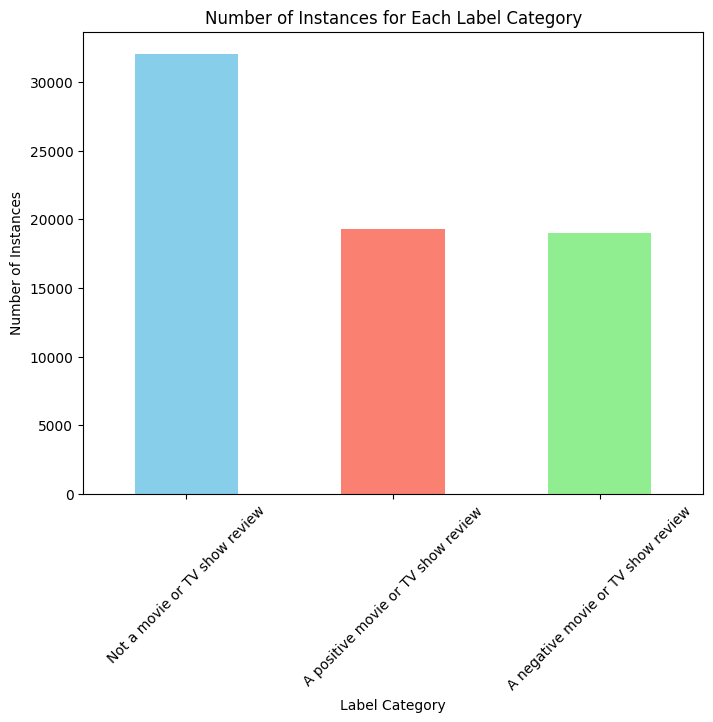

In [21]:
label_counts = train_df['Label_desc'].value_counts()
colors = ['skyblue', 'salmon', 'lightgreen']
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=colors)
plt.title('Number of Instances for Each Label Category')
plt.xlabel('Label Category')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

### Pie Chart

Pie chart visualizes the distribution of instances for each label category in our dataset

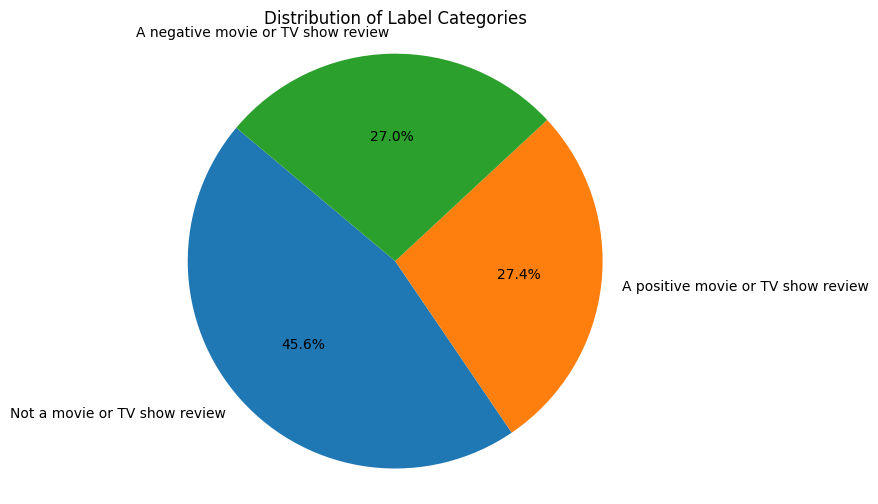

In [22]:
labels = label_counts.index
sizes = label_counts.values

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Label Categories')
plt.axis('equal')  
plt.show()


### TextToFeatures

The class provides a comprehensive solution for converting raw text data into numerical feature representations, facilitating the application of machine learning algorithms to text classification and analysis tasks.

1. Initialization: The constructor initializes an object for converting texts to features.
2. Custom Preprocessor: The custom_preprocessor function preprocesses the text data using various regular expressions (regex).
3. Feature Extraction: The class utilizes the TfidfVectorizer from scikit-learn to extract features from the preprocessed text data.
4. Fitting: The fit method fits ("trains") the TextToFeatures instance on a collection of documents (training texts).
5. Indexing: The index method returns the index in the vocabulary of a given feature value. If the feature is not present, it returns None.
6. Transformation: The transform method creates a feature matrix from a sequence of texts. 

In [23]:
class TextToFeatures:

    def __init__(self):
        
        def custom_preprocessor(text: Text) -> Text:
            linebr = r"<br /><br />?"
            linebr2 = r"<br />"
            url = r'<a\s+href="([^"]+)"'
            dash = r'\x50'
            number = number_regex2 = r'\b\d{1,4}\b'
            new_line = r'\n+'
            year_term = r'\b\d{2,4}s?\'?s?\b'
            currency = r'[£$]\d{1,4}(,\d{3})*(\.\d+)?'
            text = re.sub(linebr, " ", text)
            text = re.sub(linebr2, " ", text)
            text = re.sub(url, "<URL>", text)
            text = re.sub(dash, " ", text)
            text = re.sub(number, "<NUMBER>", text)
            text = re.sub(new_line, " ", text)
            text = re.sub(year_term,"<YEAR>", text)
            text = re.sub(currency,"<CURR>", text)
            return text
        
        self.vectorizer = TfidfVectorizer(lowercase = True, 
                                          preprocessor=custom_preprocessor, 
                                          ngram_range=(1, 2), min_df=1, max_df=1.0)
    
    
    
    def fit(self, training_texts: Iterable[Text]) -> None:

        """Fits ("trains") a TextToFeature instance on a collection of documents.
        The provided training texts are analyzed to determine the vocabulary, 
        i.e., all feature values that the converter will support. 
        Each such feature value will be associated with a unique integer index 
        that may later be accessed via the .index() method.
        It is up to the implementer exactly what features to produce from a
        text, but the features will always include some single words and some
        multi-word expressions (e.g., "need" and "to you").
        :param training_texts: The training texts."""
        
        self.vectorizer.fit(training_texts)
    
    def index(self, feature: Text) -> Union[None, int]:

        """"Returns the index in the vocabulary of the given feature value.  
        If the features isn't present, return None.
        :param feature: A feature
        :return: The unique integer index associated with the feature or None if not present.
        """

        if feature in self.vectorizer.vocabulary_:
            return self.vectorizer.vocabulary_[feature]
        else:
            return None
        
    def transform(self, texts: Iterable[Text]) -> NDArray:

        """Creates a feature matrix from a sequence of texts.
        Each row of the matrix corresponds to one of the input texts. The value
        at index j of row i is the value in the ith text of the feature
        associated with the unique integer j.
        It is up to the implementer what the value of a feature that is present
        in a text should be, though a common choice is 1. Features that are
        absent from a text will have the value 0.
        :param texts: A sequence of texts.
        :return: A matrix, with one row of feature values for each text.
        """
        
        return self.vectorizer.transform(texts)

### Classifier

 
1. Initialization: The constructor initializes the classifier, specifying that it will use a Linear Support Vector Classifier (LinearSVC).
2. Training: The train method trains the classifier.
3. Prediction: The predict method makes predictions.

In [24]:
class Classifier:

    def __init__(self):

        """Initalizes the classifier."""
        
        self.model = LinearSVC()

    def train(self, features: NDArray, labels: NDArray) -> None:

        """Trains the classifier using the given training examples.
        :param features: A feature matrix, where each row represents a text.
        Such matrices will typically be generated via TextToFeatures.
        :param labels: A label vector, where each entry represents a label.
        Such vectors will typically be generated via TextToLabels."""
        
        self.model.fit(features, labels)
        
    # just an alias for "train"
    fit = train
    
    def predict(self, features: NDArray) -> NDArray:
        
        """Makes predictions for each of the given examples.
        :param features: A feature matrix, where each row represents a text.
        Such matrices will typically be generated via TextToFeatures.
        :return: A prediction vector, where each entry represents a label.
        """
        
        return self.model.predict(features)


### Text Feature Extraction

In [25]:
text_to_features = TextToFeatures()

text_to_features.fit(train_df['TEXT'])

train_features = text_to_features.transform(train_df['TEXT'])
test_features = text_to_features.transform(test_df['TEXT'])

### Classifier Training and Prediction

In [26]:
classifier = Classifier()

classifier.train(train_features, train_df['LABEL'])

predictions = classifier.predict(test_features)

### Model Evaluation Metrics

In [27]:
train_predictions = classifier.predict(train_features)
train_accuracy = accuracy_score(train_df['LABEL'], train_predictions)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.9997440163829515


In [28]:
f1score = f1_score(train_df['LABEL'], train_predictions, average='weighted')
print("Training F1 Score:", f1score)

Training F1 Score: 0.9997440127155772


### Submission CSV Generation

In [29]:
submission_df = pd.DataFrame({'ID': test_df['ID'], 'LABEL': predictions})

submission_df.to_csv('submission.csv', index=False)

Calculating the distribution of labels in the submission and prints the count of each unique label.

In [30]:
label_counts = submission_df['LABEL'].value_counts()
print("Number of unique labels:")
print(label_counts)

Number of unique labels:
0    8234
1    4786
2    4560
Name: LABEL, dtype: int64


In [31]:
submission_df.shape

(17580, 2)